In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from nnAudio.Spectrogram import CQT1992v2
import timm
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import cv2
from scipy import signal
sys.path.insert(0, "../")

In [2]:
# from gwpy.timeseries import TimeSeries   
import matplotlib.pyplot as plt
import cv2
from joblib import Parallel, delayed

%matplotlib inline 

In [3]:
from src.transforms import minmax_bandpass_transform,  min_max_scale, minmax_turkey_bandpass_transform

In [68]:
def get_model_paths(exp_path, crietion="best"):
    folders = [x for x in os.listdir(exp_path) if "fold" in x]
    folds = sorted(folders, key=lambda x: int(x.split("_")[-1]))
    result = []
    for f in folds:
        weights = list((Path(exp_path) / f).glob("*.pth"))
        weights = [x for x in weights if "score" in x.name]
        if crietion == "last":
            weights = sorted(weights, key=lambda x: int(x.stem.split("epoch")[-1].split("_")[0]))
            result.append(weights[-1])
        if crietion == "best":
            weights = sorted(weights, key=lambda x: float(x.stem.split("score")[-1]))
            result.append(weights[-1])
    return result

[PosixPath('../weights/CustomModel_v2/00_b0_512_5cqt/fold_0/best_avg_score0.87643.pth'),
 PosixPath('../weights/CustomModel_v2/00_b0_512_5cqt/fold_1/best_avg_score0.87678.pth'),
 PosixPath('../weights/CustomModel_v2/00_b0_512_5cqt/fold_2/best_avg_score0.87581.pth'),
 PosixPath('../weights/CustomModel_v2/00_b0_512_5cqt/fold_3/best_avg_score0.87493.pth'),
 PosixPath('../weights/CustomModel_v2/00_b0_512_5cqt/fold_4/best_avg_score0.87659.pth')]

In [4]:
INPUT_PATH = Path("/home/trytolose/rinat/kaggle/grav_waves_detection/input")

In [74]:
df = pd.read_csv(INPUT_PATH / "training_labels.csv")
files = list((INPUT_PATH / "train").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
df["path"] = df["id"].apply(lambda x: FILE_PATH_DICT[x])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
df["fold"] = -1
for f, (train_ids, val_ids) in enumerate(skf.split(df.index, y=df["target"])):
    df.loc[val_ids, "fold"] = f
    
# df = df.set_index('id', drop=True)

In [77]:
df

,id,target,path,fold
0,00000e74ad,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
1,00001f4945,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
2,0000661522,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,4
3,00007a006a,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,3
4,0000a38978,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
...,...,...,...,...
559995,ffff9a5645,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
559996,ffffab0c27,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,2
559997,ffffcf161a,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,2
559998,ffffd2c403,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,4


In [75]:
df_oof = pd.read_csv("../oof_00_b0_512_5cqt.csv")

In [78]:
df_oof['hard'] = 0
df_oof.loc[(df_oof['pred']<0.4) & (df_oof['target']==1), 'hard'] = 1

,id,target,path,fold,pred
0,00000e74ad,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0,0.326019
1,00001f4945,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0,0.169916
448000,0000661522,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,4,0.184941
336000,00007a006a,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,3,0.137516
2,0000a38978,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0,0.229696
...,...,...,...,...,...
111999,ffff9a5645,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0,0.148705
335997,ffffab0c27,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,2,0.107502
335998,ffffcf161a,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,2,0.856273
559999,ffffd2c403,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,4,0.169005


In [65]:
print(df_oof[(df_oof['target']==1) & (df_oof['pred']<0.5)].shape) 
print(df_oof[(df_oof['target']==0) & (df_oof['pred']>0.5)].shape) 

(101710, 5)
(8790, 5)


In [72]:
cts = df_oof[(df_oof['target']==1) & (df_oof['pred']<0.5)]['fold'].value_counts().sort_index().values

In [73]:
paths = get_model_paths("../weights/CustomModel_v2/00_b0_512_5cqt/")
paths = [x.name for x in paths]
for x, y in zip(paths, cts):
    print(x, y)

best_avg_score0.87643.pth 21532
best_avg_score0.87678.pth 20057
best_avg_score0.87581.pth 19581
best_avg_score0.87493.pth 20452
best_avg_score0.87659.pth 20088


In [7]:
curr_params = {
    'sr': 2048,
    'fmin': 20,
    'fmax': 1024,
    'hop_length': 32,
    'bins_per_octave': 8,
    'filter_scale': 1,
}


def apply_bandpass(x, lf=30, hf=400, order=8, sr=2048):
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization

def CQT_transform(x, params=curr_params):
    cqt = CQT1992v2(**params)
    x = torch.tensor(x).float().unsqueeze(1)
    
    out = cqt(x).numpy()
    print(out.shape)
    return out

def plot_3ch(img):
    plt.figure(figsize=(40, 40))
    plt.subplot(131)
    plt.imshow(img[0])
    plt.subplot(132)
    plt.imshow(img[1])
    plt.subplot(133)
    plt.imshow(img[2])
    plt.show()

In [8]:
pparams = {
    'sr': 2048,
    'fmin': 20,
    'fmax': 1024,
    'hop_length': 32,
    'bins_per_octave': 8,
    'filter_scale': 1,
}

# pparams2 = {
#     'sr': 2048,
#     'fmin': 30,
#     'fmax': 500,
#     'hop_length': 16,
#     'bins_per_octave': 16,
#     'filter_scale': 0.5,
# }
pparams2 = {
    'sr': 2048,
    'fmin': 20,
    'fmax': 1024,
    'hop_length': 16,
    'bins_per_octave':16,
    'filter_scale': 1,
}

In [56]:
wave_id = "00161459f4"

CQT kernels created, time used = 0.0100 seconds
(3, 46, 129)


/home/trytolose/miniconda3/envs/audio/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


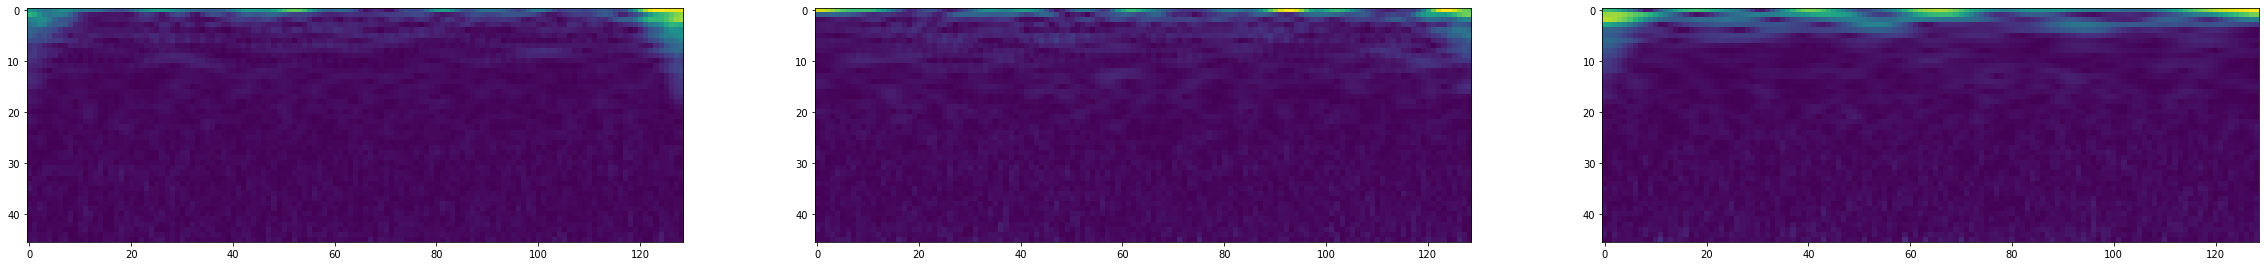

In [57]:
wave = np.load(df.loc[wave_id, "path"])
# x = apply_bandpass(wave)
x =  CQT_transform(wave)
plot_3ch(x)

CQT kernels created, time used = 0.0054 seconds
(3, 46, 129)


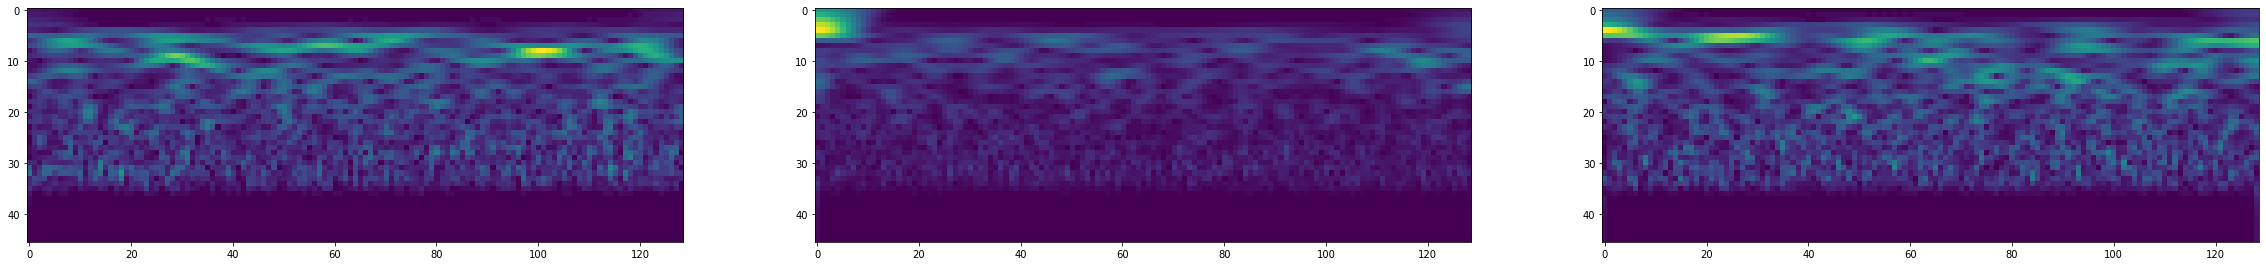

In [58]:
wave = np.load(df.loc[wave_id, "path"])
x = apply_bandpass(wave)
x =  CQT_transform(x)
plot_3ch(x)

CQT kernels created, time used = 0.0123 seconds
(3, 91, 257)


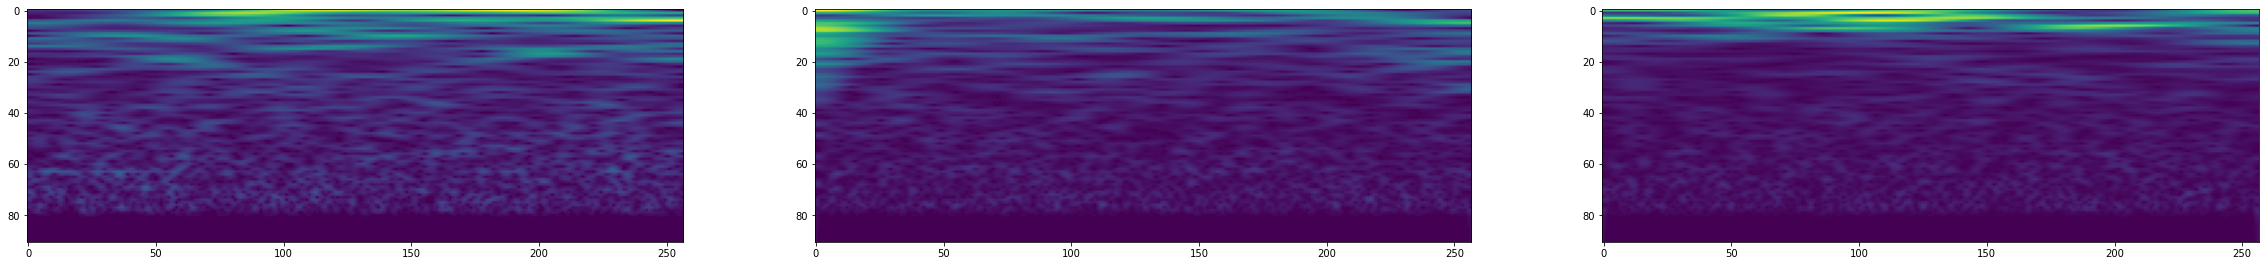

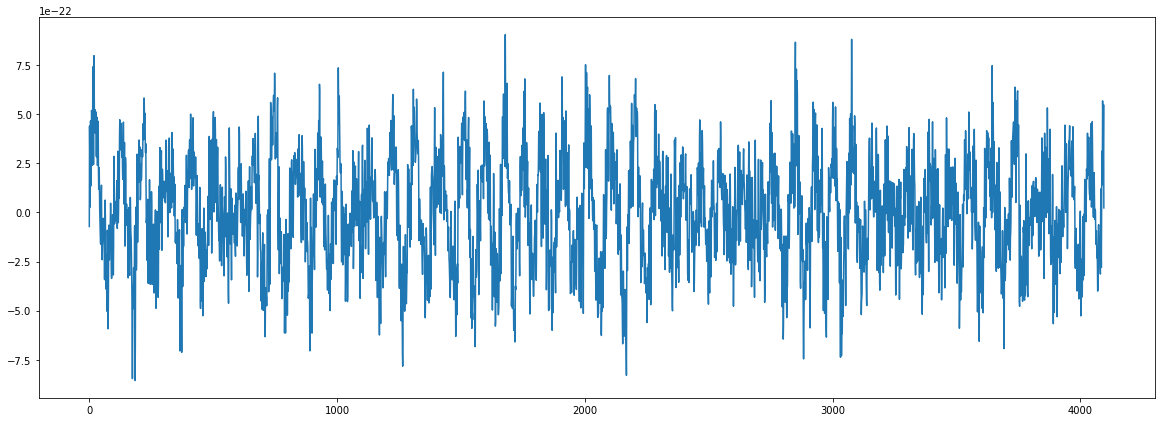

In [59]:
wave = np.load(df.loc[wave_id, "path"])
# plt.figure(figsize=(20, 7))
# plt.plot(wave[2])
# plt.show()
wave = apply_bandpass(wave,lf=20, hf=600)
x =  CQT_transform(wave, pparams2)
plot_3ch(x)
plt.figure(figsize=(20, 7))
plt.plot(wave[2])
plt.show()

In [392]:
_df = pd.read_csv(INPUT_PATH / "training_labels.csv")
files = list((INPUT_PATH / "train").rglob("*.npy"))
FILE_PATH_DICT = {x.stem: str(x) for x in files}
_df["path"] = _df["id"].apply(lambda x: FILE_PATH_DICT[x])

In [231]:
oof_andr = np.load("oof_eff0_v2.npy")

In [232]:
_df['pred_a'] = oof_andr

In [233]:
df_wave = pd.read_csv("train_oof_wavenet_f023.csv")

In [234]:
_df = pd.merge(_df, df_wave[['id', 'pred']], on='id', how='left').dropna()

In [235]:
_df[(_df['pred']>0.8) & (_df['pred_a']<0.3) & (_df['target']==1)]

,id,target,path,pred_a,pred
28661,0d0cb40e57,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.235500,0.888693
58812,1abe17dfdc,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.261379,0.811504
119500,367345300b,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.228799,0.824000
181659,530aabcbc9,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.248760,0.893057
196545,59dbe02626,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.248305,0.846275
229986,6949e6daaf,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.299927,0.845351
247371,71478b921b,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.237287,0.804667
372974,aa91d540bd,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.292880,0.809079
433699,c68761beb3,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.229091,0.802359
435511,c7537deee1,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.253526,0.873794


In [269]:
_df[(_df['pred']<0.1) & (_df['pred_a']<0.1) & (_df['target']==1)][:30]

,id,target,path,pred_a,pred
682,004b9631f5,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.085712,0.082421
8254,03b56100c9,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.085169,0.091034
12859,05d94b0810,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.091584,0.097985
18100,0836a63440,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.097564,0.097703
36529,109c59c515,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.089886,0.092079
39655,12090e9161,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.079466,0.071272
45140,14795758d0,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.097128,0.097564
46769,153574c43f,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.097134,0.096172
47944,15beb25a3b,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.073003,0.078043
53509,1859ac85ab,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.097941,0.090216


In [252]:
_df[(_df['pred']<0.1) & (_df['pred_a']<0.1) & (_df['target']==0)]

,id,target,path,pred_a,pred
197,00164d4b5e,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.084043,0.092889
249,001b6bc711,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.087096,0.090971
596,0042e4b17c,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.083719,0.071140
814,0057d10998,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.098256,0.097671
1176,008086329a,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.083512,0.079777
...,...,...,...,...,...
556911,fe930f8e83,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.089147,0.091202
557709,feefc0f518,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.091785,0.096095
558436,ff4a57e716,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.097260,0.096856
558989,ff8b0da9da,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0.091277,0.086750


In [415]:
import torch
import torch.nn as nn
import math

In [ ]:
@tf.function
def kron(a, b):
    return tf.numpy_function(np.kron, [a, b], tf.complex64)

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2, 'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]), next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(kron(tf.ones([self.num_scales, 1], dtype=tf.complex64), f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:, self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32), tf.zeros([self.batch_size, self.num_scales, inputs.shape[-1]], dtype = tf.float32)))
        return cwt
    
# scale input to range 0.0 - upper
class Scaler(keras.layers.Layer):
    def __init__(self, upper=1.0):
        super(Scaler, self).__init__()
        self.upper = tf.cast(upper, dtype=tf.float32) # upper value (typically 1.0 or 255.0 for image CNNs)
    
    def call(self, inputs):
        min_val = tf.math.reduce_min(inputs)
        max_val = tf.math.reduce_max(tf.math.subtract(inputs, min_val))
        return tf.math.multiply(tf.math.subtract(inputs, min_val), self.upper/max_val)
        
    
# Stack three channels into RGB image
class RGBStack(keras.layers.Layer):
    def __init__(self):
        super(RGBStack, self).__init__()
        
    def call(self, inputs):
        return tf.stack(inputs, axis = 3)

In [ ]:
class CWT_TF(nn.Module)

In [398]:
batch_size = 7 
nv = 8 # number of voices
sr = 2048 # sample rate (Hz)
flow = 8 # lowest frequency of interest (Hz)
fhigh = 500 # highest frequency of interest (Hz)

In [399]:
input_shape = np.array([3, 4096])

In [427]:
max_scale = input_shape[-1] // (np.sqrt(2) * 2)
if max_scale <= 1:
    max_scale = input_shape[-1] // 2
max_scale = np.floor(nv * np.log2(max_scale))

scales = 2 * (2**(1/nv)) ** np.arange(0, max_scale + 1)

frequencies = sr * (6 / (2 * np.pi)) / scales
frequencies = frequencies[frequencies >= flow] # remove low frequencies
scales = scales[0:len(frequencies)]
frequencies = frequencies[frequencies <= fhigh] # remove high frequencies
scales = scales[len(scales)-len(frequencies):len(scales)]
# # wavft
padvalue = input_shape[-1] // 2
n = padvalue*2+input_shape[-1]
omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
omega = omega*(2 * np.pi) / n
omega = np.concatenate((np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1]))
_wft = np.zeros([scales.size, omega.size])
for jj, scale in enumerate(scales):
    expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
    _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)

# # parameters we want to use during call():
# self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
wft = torch.tensor(_wft)
padvalue = padvalue
num_scales = scales.shape[-1]

torch.Size([48, 1]) torch.Size([8192])
torch.Size([48, 8192])


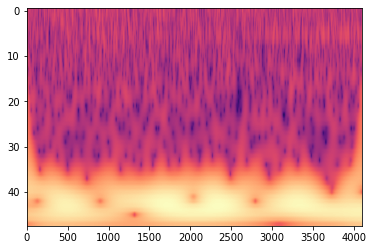

In [592]:
x = np.load(df.iloc[0,1])[0]
x = x/x.max()

next_data = torch.tensor(x.copy())
x = torch.cat([torch.flip(next_data[0:padvalue], dims=[0]), next_data, torch.flip(next_data[-padvalue:], dims=[0])], dim=0)
x = x.type(torch.complex64)
f = torch.fft.fft(x)
print(torch.ones(num_scales, 1).type(torch.complex64).shape, f.shape)
print(torch.kron(torch.ones(num_scales, 1).type(torch.complex64), f).shape)

cwtcfs = torch.fft.ifft(torch.kron(torch.ones(num_scales, 1).type(torch.complex64), f) * wft.type(torch.complex64))

logcwt = torch.log(torch.abs(cwtcfs[:, padvalue:padvalue + next_data.shape[-1]]))

logcwt.shape
y = logcwt.numpy()

# min_v = y.min()
# max_v = np.max(y-min_v)

# print(min_v, max_v)
# y = (y - min_v)*(1/max_v)

plt.imshow(np.squeeze(y), cmap='magma', aspect='auto') 

In [504]:
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

In [ ]:
torch.Size([48, 1]) torch.Size([8192])
torch.Size([48, 8192])


torch.Size([3, 48, 8192])


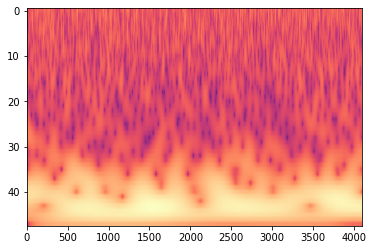

In [572]:
x = np.load(df.iloc[0,1])#[0]
x = torch.tensor(x)
# next_data = torch.tensor(x.copy())
# x = torch.cat([torch.flip(next_data[0:padvalue], dims=[0]), next_data, torch.flip(next_data[-padvalue:], dims=[0])], dim=0)

x_left_pad = torch.flip(x[:, 0:padvalue], dims=[1])
x_right_pad = torch.flip(x[:, -padvalue:], dims=[1])
x_padded = torch.cat([x_left_pad, x, x_right_pad], dim=1)
x_padded.shape

x_padded = x_padded.type(torch.complex128)
f = torch.fft.fft(x_padded, dim=1)

kron_prod = kron(torch.ones(3, num_scales, 1).type(torch.complex64), f.unsqueeze(1))
cwtcfs = torch.fft.ifft(kron_prod * torch.stack([wft.type(torch.complex64), wft.type(torch.complex64), wft.type(torch.complex64)]), dim=2)


logcwt = torch.log(torch.abs(cwtcfs[:, :, padvalue:padvalue + x.shape[-1]]))

y = logcwt.numpy()
# # min_v = y.min()
# # max_v = np.max(y-min_v)

# # print(min_v, max_v)
# # y = (y - min_v)*(1/max_v)

plt.imshow(y[2], cmap='magma', aspect='auto') 

In [580]:
print(wft.shape)

print(wft.unsqueeze(0).repeat(3, 1, 1).shape)

torch.Size([48, 8192])
torch.Size([3, 48, 8192])


In [767]:
class CWT_TF(nn.Module):
    def __init__(
        self,
        nv=8,  # number of voices
        sr=2048,  # sample rate (Hz)
        flow=8,  # lowest frequency of interest (Hz)
        fhigh=500,  # highest frequency of interest (Hz)
    ):
        super().__init__()
        self.nv = nv
        self.sr = sr
        self.flow = flow
        self.fhigh = fhigh

        self.get_const()

    def kron(self, a, b):
        """
        Kronecker product of matrices a and b with leading batch dimensions.
        Batch dimensions are broadcast. The number of them mush
        :type a: torch.Tensor
        :type b: torch.Tensor
        :rtype: torch.Tensor
        """
        siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
        res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
        siz0 = res.shape[:-4]
        return res.reshape(siz0 + siz1)

    def get_const(self):

        input_shape = np.array([3, 4096])
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))

        scales = 2 * (2 ** (1 / self.nv)) ** np.arange(0, max_scale + 1)

        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow]  # remove low frequencies
        scales = scales[0 : len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh]  # remove high frequencies
        scales = scales[len(scales) - len(frequencies) : len(scales)]
        # # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue * 2 + input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega * (2 * np.pi) / n
        omega = np.concatenate(
            (np.array([0]), omega, -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1])
        )
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -((scale * omega - 6) ** 2) / 2 * (omega > 0)
            _wft[jj,] = (
                2 * np.exp(expnt) * (omega > 0)
            )

        # # parameters we want to use during call():
        self.wft = torch.tensor(_wft)#.cuda()
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
        self.cron_ones_tensor = torch.ones(self.num_scales, 1).type(torch.complex64)#.cuda()

    def forward(self, x):

        bs, wave_len = x.shape
        x_left_pad = torch.flip(x[:, 0 : self.padvalue], dims=[1])
        x_right_pad = torch.flip(x[:, -self.padvalue :], dims=[1])
        x = torch.cat([x_left_pad, x, x_right_pad], dim=1)

        x = x.type(torch.complex128)
        f = torch.fft.fft(x, dim=1)

        kron_prod = self.kron(self.cron_ones_tensor.unsqueeze(0).repeat(bs, 1, 1), f.unsqueeze(1))
        cwtcfs = torch.fft.ifft(kron_prod * self.wft.unsqueeze(0).repeat(bs, 1, 1), dim=2)

        logcwt = torch.log(torch.abs(cwtcfs[:, :, self.padvalue : self.padvalue + wave_len]))
#         x = nn.functional.interpolate(logcwt.unsqueeze(1), (128, 128)).float().squeeze()
        return logcwt

In [809]:
model = CWT_TF(flow=20, fhigh=500, nv=24)

In [810]:
max=-0.52181476354599
min=-18.470922470092773
mean=-6.318470001220703
std = 0.031600773334503174
max_3=np.array([-1.8969368,  -1.8041766,  -0.52181476])
min_3=np.array([-18.470922, -16.920744, -15.612136])
mean_3=np.array([-6.9816833, -6.902704,  -5.090784 ])
std_3=np.array([0.02738766, 0.02743766, 0.02261995])

In [814]:
df

,target,path,fold
id,,,
00000e74ad,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
00001f4945,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
0000661522,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,4
00007a006a,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,3
0000a38978,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
...,...,...,...
ffff9a5645,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,0
ffffab0c27,0,/home/trytolose/rinat/kaggle/grav_waves_detect...,2
ffffcf161a,1,/home/trytolose/rinat/kaggle/grav_waves_detect...,2


In [815]:
x = np.load(df.loc['3423e21d54', 'path'])
x = minmax_turkey_bandpass_transform(x, dict(lf=20, hf=500))
xx = model(torch.tensor(x))

In [ ]:
y = xx.numpy()
# print(y.mean(), y.std())
# y=(y - mean)#/std
# print(y.min(axis=(1,2)))
# print(y.max(axis=(1,2)))
# print(y.mean(), y.std())
plt.figure(figsize=(20,10))
plt.imshow(y[2], cmap='magma', aspect='auto') 

In [ ]:
y = xx.numpy()
# print(y.mean(), y.std())
# y=(y - mean)#/std
# print(y.min(axis=(1,2)))
# print(y.max(axis=(1,2)))
# print(y.mean(), y.std())
plt.imshow(y[0], cmap='magma', aspect='auto') 

In [82]:
y_true = np.random.randint(0, 2, size=(100,))
y_true                         

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0])

In [84]:
metrics.roc_auc_score(np.random.randint(0, 2, size=(100,)), np.random.rand(100,)*10+3)

0.4885954381752701